## Import

In [2]:
# !pip install pandas
# !pip install numpy
# # install sklearn
# !pip install scikit-learn
# !pip install tqdm
# !pip install seaborn
# !pip install prophet
# !pip install lightgbm
# !pip install optuna

In [3]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMRegressor
from datetime import datetime, timedelta, timezone
from itertools import combinations, product

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
import gc
import warnings
warnings.filterwarnings(action='ignore') 

# Device & Path

In [8]:
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
# torch.backends.mps.is_available()

In [9]:
# PATH
DATA_PATH  = '../DATA'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TRAIN_CSV  = os.path.join(DATA_PATH, 'train.csv')
SAMPLE_PATH = os.path.join(DATA_PATH, 'sample_submission.csv')

## Hyperparameter Setting

In [10]:
CFG = {
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'SEED':41
}

## Fixed RandomSeed

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = True


seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [12]:
df_train = pd.read_csv(TRAIN_CSV)
df_ss = pd.read_csv(SAMPLE_PATH)
df_train

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...,...
987995,20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980
987996,20230530,A000540,흥국화재,50218,3250,3255,3195,3215
987997,20230530,A003280,흥아해운,130664,1344,1395,1340,1370
987998,20230530,A037440,희림,141932,9170,9260,9170,9200


## columns 
1. '일자': 이 컬럼은 특정 거래가 발생한 날짜를 나타냅니다. "YYYY-MM-DD" 형식으로 표현됩니다.

2. '종목코드': 각각의 주식을 식별하는 고유한 코드입니다. 한국의 경우 종목코드는 대부분 6자리 숫자로 이루어져 있습니다. (ex - A060310)

3. '종목명': 주식의 공식 이름을 나타냅니다. 이 이름은 주로 회사의 이름을 반영하며, 시장에서 해당 주식을 찾을 때 사용됩니다.

4. '거래량': 특정 일자에 해당 주식이 거래된 총 주식 수를 나타냅니다. 거래량은 시장의 활동 수준과 관심도를 반영하는 중요한 지표입니다.

5. '시가': 주식 시장이 개장했을 때의 첫 거래 가격을 의미합니다. 이는 해당 날의 시장 흐름을 이해하는데 도움이 됩니다.

6. '고가': 특정 일자에 해당 주식이 거래된 가장 높은 가격을 나타냅니다.

7. '저가': 특정 일자에 해당 주식이 거래된 가장 낮은 가격을 나타냅니다.

8. '종가': 주식 시장이 마감했을 때의 마지막 거래 가격을 의미합니다. 종가는 해당 일의 주식 가격 변동을 반영하며, 이후의 시장 분석에 중요한 기준이 됩니다.

In [13]:
# change columns name
df = df_train.rename(columns={
    '일자': 'date',
    '종목코드': 'code',
    '종목명': 'name',
    '거래량': 'volume',
    '시가': 'open',
    '고가': 'high',
    '저가': 'low',
    '종가': 'close'
})
# datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df_price = df.pivot(index='date', columns='code', values='close')

df_processed = df.copy()
le = preprocessing.LabelEncoder()
df_processed['code'] = le.fit_transform(df_processed['code'])  
df_processed.drop(columns=['name'], inplace=True)

# df_processed.set_index('date', inplace=True)


In [14]:
df_processed

,date,code,volume,open,high,low,close
0,2021-06-01,971,166690,2890,2970,2885,2920
1,2021-06-01,1267,63836,5860,5940,5750,5780
2,2021-06-01,280,103691,35500,35600,34150,34400
3,2021-06-01,929,462544,14600,14950,13800,14950
4,2021-06-01,1789,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...
987995,2023-05-30,1562,272284,3005,3035,2955,2980
987996,2023-05-30,27,50218,3250,3255,3195,3215
987997,2023-05-30,146,130664,1344,1395,1340,1370
987998,2023-05-30,732,141932,9170,9260,9170,9200


In [57]:
ttt = df_predictions[888][['ds','trend','yhat','yhat_lower','yhat_upper','additive_terms']]
ttt['code'] = 888
pd.concat([tt,ttt], axis=0)

,ds,trend,yhat,yhat_lower,yhat_upper,additive_terms,code
0,2021-06-03,200157.500200,204744.980104,191776.710871,218186.744673,4587.479904,999
1,2021-06-04,199679.913832,204230.347213,190418.179159,216571.972276,4550.433380,999
2,2021-06-07,198247.154729,202999.950699,189711.340753,215990.465885,4752.795970,999
3,2021-06-08,197769.568361,202443.899460,189847.491716,215965.500626,4674.331099,999
4,2021-06-09,197291.981993,202014.285001,189090.029310,214577.723770,4722.303008,999
...,...,...,...,...,...,...,...
502,2023-06-10,12236.702780,12423.843218,10955.791224,13879.586075,187.140439,888
503,2023-06-11,12232.012553,12419.152781,11047.711064,13765.419535,187.140228,888
504,2023-06-12,12227.322325,12177.210636,10731.715733,13688.366472,-50.111689,888
505,2023-06-13,12222.632098,12167.391210,10744.124946,13607.006793,-55.240889,888


In [75]:
df_predictions = pd.read_pickle('/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/DATA/df_predictions.pkl')
df_predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-06-03,158016.423600,170714.164237,180110.788097,158016.423600,158016.423600,17448.602459,17448.602459,17448.602459,-10333.473311,-10333.473311,-10333.473311,27782.075770,27782.075770,27782.075770,0.0,0.0,0.0,175465.026059
1,2021-06-04,159177.654034,170968.240848,180432.848404,159177.654034,159177.654034,16769.680298,16769.680298,16769.680298,-10523.070760,-10523.070760,-10523.070760,27292.751058,27292.751058,27292.751058,0.0,0.0,0.0,175947.334332
2,2021-06-07,162661.345336,172215.382825,181567.838372,162661.345336,162661.345336,14527.147973,14527.147973,14527.147973,-11252.222778,-11252.222778,-11252.222778,25779.370751,25779.370751,25779.370751,0.0,0.0,0.0,177188.493309
3,2021-06-08,163822.575769,173749.939189,182870.554436,163822.575769,163822.575769,14588.359136,14588.359136,14588.359136,-10849.014820,-10849.014820,-10849.014820,25437.373956,25437.373956,25437.373956,0.0,0.0,0.0,178410.934906
4,2021-06-09,164983.806203,174448.680177,184001.530543,164983.806203,164983.806203,14530.169863,14530.169863,14530.169863,-10710.976514,-10710.976514,-10710.976514,25241.146376,25241.146376,25241.146376,0.0,0.0,0.0,179513.976066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2023-06-10,689.710851,731.608945,794.658238,687.317204,691.510619,70.737390,70.737390,70.737390,-3.547997,-3.547997,-3.547997,74.285387,74.285387,74.285387,0.0,0.0,0.0,760.448240
503,2023-06-11,690.465234,731.805437,795.319593,687.385327,693.022912,74.437099,74.437099,74.437099,-3.548002,-3.548002,-3.548002,77.985101,77.985101,77.985101,0.0,0.0,0.0,764.902333
504,2023-06-12,691.219617,750.047468,813.095938,687.322899,694.377468,90.663683,90.663683,90.663683,10.586010,10.586010,10.586010,80.077673,80.077673,80.077673,0.0,0.0,0.0,781.883300
505,2023-06-13,691.974000,750.909280,817.513008,687.348903,695.860225,91.417611,91.417611,91.417611,11.009359,11.009359,11.009359,80.408252,80.408252,80.408252,0.0,0.0,0.0,783.391611


In [59]:
merged_df = pd.DataFrame()
for code, df in tqdm(df_predictions.items()):
    df['code'] = code
    df['ds'] = pd.to_datetime(df['ds'], format='%Y%m%d')
    df = df[['ds','trend','yhat','yhat_lower','yhat_upper','additive_terms','code']]
    merged_df = pd.concat([merged_df, df], axis=0)
len(merged_df)

  0%|          | 0/2000 [00:00<?, ?it/s]

1014000

In [68]:
pivot_df = merged_df.pivot(index='ds', columns='code', values='yhat')
pivot_df

code,A000020,A000040,A000050,A000070,A000080,A000100,A000120,A000140,A000150,A000180,...,A363280,A365590,A368770,A369370,A373200,A375500,A378850,A383220,A383310,A383800
ds,,,,,,,,,,,,,,,,,,,,,
2021-06-03,14642.175790,1284.632591,14875.636310,107470.621020,38726.675070,63575.991855,176360.755300,18374.404032,89900.600070,2951.464145,...,29670.369098,2196.487030,2070.613774,1915.635286,1922.492030,146089.280950,6336.453996,495506.943305,174608.872800,11362.343028
2021-06-04,14657.703840,1284.643244,14885.635744,107670.973824,38702.706266,63538.213006,176139.251391,18335.686188,90401.210683,2954.411328,...,29704.478130,2200.366720,2064.779983,1941.538641,1986.123251,145689.423906,6337.121301,499071.906758,175013.054210,11345.943544
2021-06-07,14650.284694,1278.366785,14805.235103,107727.286454,38577.902439,63555.783553,176293.164841,18206.854503,90959.337181,2944.904668,...,29776.958325,2216.047504,2088.916338,1936.679733,1940.109160,145669.422486,6319.170994,505938.269989,175995.133105,11323.465973
2021-06-08,14684.635951,1279.035067,14813.140439,107670.431812,38514.518528,63643.464720,176210.042354,18154.637852,90748.040824,2946.351120,...,29888.230895,2212.927910,2096.479111,1941.065371,1955.904719,145416.105578,6331.823608,508066.651159,175175.229264,11320.039433
2021-06-09,14728.111602,1277.063896,14775.951959,107635.426830,38396.940150,63467.226478,176244.245238,18080.320671,90849.588161,2938.329887,...,29824.633287,2223.615712,2088.505336,1968.005590,1898.706026,145229.262174,6331.502858,505417.789328,174563.650257,11300.569648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-10,8672.783131,596.147576,10667.461009,82471.863682,22389.006616,55007.503030,73310.466631,9640.611674,98941.563431,2023.951046,...,9316.144190,2304.565952,3980.573719,2167.264781,5768.129706,28619.080915,4096.723250,140501.798110,51244.952854,7718.493759
2023-06-11,8670.524507,596.939215,10664.420536,82527.010310,22367.450228,55001.750173,73244.533395,9635.444837,99023.807622,2023.866885,...,9312.900797,2314.505006,3989.499566,2166.524977,5761.793526,28599.505660,4099.497404,140516.594623,51305.921842,7715.390370
2023-06-12,8674.580174,648.608589,10432.927906,78676.364772,21840.018799,54680.559105,77337.028796,9220.637289,102000.068285,2042.292398,...,10805.507304,2367.915789,3866.892754,2004.793430,5562.031004,33065.162469,4367.231704,143291.096072,67904.764990,8312.327614


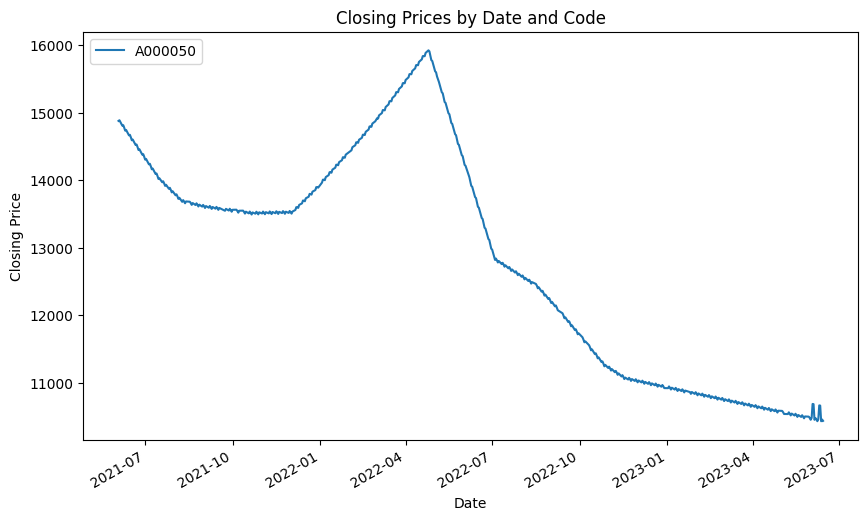

In [70]:
# Plot the closing prices
pivot_df[pivot_df.columns[2]].plot(figsize=(10, 6))
plt.title('Closing Prices by Date and Code')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='upper left')
plt.show()


In [48]:
# lag features
def create_lag_features(df, lag_days):
    df = df.copy()
    for i in range(1, lag_days + 1):
        df[f'lag_{i}'] = df.groupby('code')['close'].shift(i)
        df[f'lag_{i}_volume'] = df.groupby('code')['volume'].shift(i)
        df[f'lag_{i}_open'] = df.groupby('code')['open'].shift(i)
        df[f'lag_{i}_high'] = df.groupby('code')['high'].shift(i)
        df[f'lag_{i}_low'] = df.groupby('code')['low'].shift(i)
    return df
# def create_lag_features(df, lag_days):
#     df = df.copy()
#     for i in range(1, lag_days + 1):
#         df[f'lag_{i}'] = df.groupby('code')['close'].shift(i)
#     return df

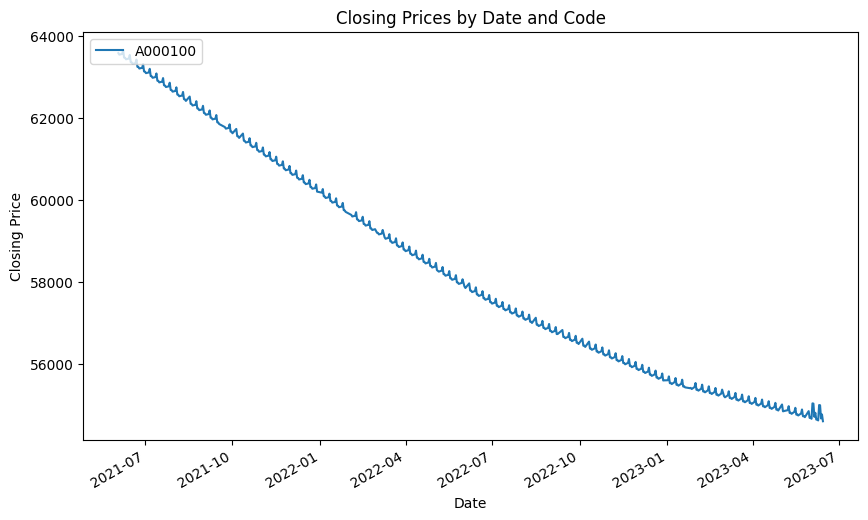

In [73]:
# Plot the closing prices
pivot_df[pivot_df.columns[5]].plot(figsize=(10, 6))
plt.title('Closing Prices by Date and Code')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='upper left')
plt.show()


- lag data를 close값에만 적용해서 5일을 생성 하는 함수

- 예측을 위한 test data frame 생성 (2023년 5월 31일 - 2023년 6월 24일)

In [11]:
# # create an empty dataframe for test data
# test_data = pd.DataFrame()

# # set the date range for test data
# test_data_dates = pd.date_range(start='2023-05-31', end='2023-06-24', freq='B')

# for code in df['code'].unique():
#     # create a dataframe for this code
#     df_code = pd.DataFrame({
#         'date': test_data_dates,
#         'code': code,
#     })
    
#     # get the last 5 days' data for this code
#     last_5_days = df[df['code'] == code].iloc[-5:]
    
#     # create lag features
#     for i in range(1, 6):
#         df_code[f'lag_{i}'] = last_5_days[f'lag_{i}'].values
        
#     # append to test data
#     test_data = test_data.append(df_code, ignore_index=True)


In [30]:
# create an empty dataframe for test data
test_data = pd.DataFrame(columns=['date', 'code', 'close'])

# set the date range for test data
test_data_dates = pd.date_range(start='2023-05-31', end='2023-06-24', freq='B')

for code in df['code'].unique():
    # create a dataframe for this code
    df_code = pd.DataFrame({
        'date': test_data_dates,
        'code': code,
        'volume' : np.nan,
        'open': np.nan,
        'high': np.nan,
        'low': np.nan,
        'close': np.nan  # add the 'close' column with NaN values
    })
    
    # sort the data by date for this code
    df_code_sorted = df[df['code'] == code].sort_values('date')
    
    # get the last 5 days' data for this code
    last_5_days = df_code_sorted.tail(5)
    
    # create lag features
    for i in range(1, 6):
        df_code[f'lag_{i}'] = last_5_days['close'].values[i-1]
        df_code[f'lag_{i}_volume'] = last_5_days['volume'].values[i-1]
        df_code[f'lag_{i}_open'] = last_5_days['open'].values[i-1]
        df_code[f'lag_{i}_high'] = last_5_days['high'].values[i-1]
        df_code[f'lag_{i}_low'] = last_5_days['low'].values[i-1]
        
    # append to test data
    test_data = test_data.append(df_code, ignore_index=True)


In [31]:
test_data.columns

Index(['date', 'code', 'close', 'volume', 'open', 'high', 'low', 'lag_1',
       'lag_1_volume', 'lag_1_open', 'lag_1_high', 'lag_1_low', 'lag_2',
       'lag_2_volume', 'lag_2_open', 'lag_2_high', 'lag_2_low', 'lag_3',
       'lag_3_volume', 'lag_3_open', 'lag_3_high', 'lag_3_low', 'lag_4',
       'lag_4_volume', 'lag_4_open', 'lag_4_high', 'lag_4_low', 'lag_5',
       'lag_5_volume', 'lag_5_open', 'lag_5_high', 'lag_5_low'],
      dtype='object')

In [32]:
df_test = test_data.copy()

- train model 함수 생성

In [39]:
# def train_model(data, params):
#     train_size = int(len(data) * 0.95)  # Use 95% of the data for training
#     train_data = data[:train_size]
#     valid_data = data[train_size:]

#     train_dataset = lgb.Dataset(train_data[features], label=train_data['close'])
#     valid_dataset = lgb.Dataset(valid_data[features], label=valid_data['close'])
    
#     model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], verbose_eval=100)
#     return model

# # parameters for LightGBM
# params = {
#     'learning_rate': 0.01,
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'feature_fraction': 0.75,
#     'bagging_fraction': 0.75,
#     'bagging_freq': 10,
#     'num_leaves': 128,
#     'verbose': -1,
#     'max_depth': 5,
#     'random_seed': 42,
#     'n_jobs': -1,
# }

# # features
# features = [f'lag_{i}' for i in range(1, 6)]  # ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

# # create lag features
# df = create_lag_features(df_processed, 5)

# # split the data into train and test set
# train_data = df[df['date'] <= '2023-05-30']
# test_data = df_test[df_test['date'] > '2023-05-30']

# # add 'close' column to test_data
# test_data['close'] = np.nan

# for code in df['code'].unique():
#     train_data_code = train_data[train_data['code'] == code].dropna()
#     test_data_code = test_data[test_data['code'] == code]
    
#     if len(train_data_code) > 0:
#         # train the model
#         model = train_model(train_data_code, params)
        
#         # predict 'close' values
#         for i, row in test_data_code.iterrows():
#             test_data.loc[i, 'close'] = model.predict(row[features].values.reshape(1, -1))
            
#             # update lag features
#             for j in range(5, 0, -1):
#                 if j > 1:
#                     test_data.loc[i, f'lag_{j}'] = row[f'lag_{j - 1}']
#                 else:
#                     test_data.loc[i, 'lag_1'] = test_data.loc[i, 'close']


[100]	training's rmse: 223.842	valid_1's rmse: 280.936
[100]	training's rmse: 321.468	valid_1's rmse: 705.557
[100]	training's rmse: 2014.05	valid_1's rmse: 455.386
[100]	training's rmse: 1247.67	valid_1's rmse: 1148.36
[100]	training's rmse: 1577.4	valid_1's rmse: 749.812
[100]	training's rmse: 1404.77	valid_1's rmse: 1288.17
[100]	training's rmse: 357.606	valid_1's rmse: 296.64
[100]	training's rmse: 6301.54	valid_1's rmse: 4541.2
[100]	training's rmse: 742.656	valid_1's rmse: 218.053
[100]	training's rmse: 311.241	valid_1's rmse: 280.764
[100]	training's rmse: 18317.8	valid_1's rmse: 11875.7
[100]	training's rmse: 2353.36	valid_1's rmse: 1236.65
[100]	training's rmse: 4179.3	valid_1's rmse: 2478.69
[100]	training's rmse: 2120.18	valid_1's rmse: 2843.55
[100]	training's rmse: 12178.8	valid_1's rmse: 16452.8
[100]	training's rmse: 2904.57	valid_1's rmse: 2776.24
[100]	training's rmse: 11418	valid_1's rmse: 15180.7
[100]	training's rmse: 238.178	valid_1's rmse: 110.733
[100]	training's

In [35]:
df_processed

,date,code,close,lag_1,lag_1_volume,lag_1_open,lag_1_high,lag_1_low,lag_2,lag_2_volume,...,lag_4,lag_4_volume,lag_4_open,lag_4_high,lag_4_low,lag_5,lag_5_volume,lag_5_open,lag_5_high,lag_5_low
0,2021-06-01,971,2920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-01,1267,5780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-06-01,280,34400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-06-01,929,14950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-06-01,1789,29050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987995,2023-05-30,1562,2980,3000.0,361608.0,3085.0,3090.0,2985.0,3085.0,556467.0,...,3035.0,1797571.0,2985.0,3150.0,2950.0,2965.0,3107939.0,2870.0,3110.0,2850.0
987996,2023-05-30,27,3215,3235.0,24860.0,3320.0,3320.0,3230.0,3295.0,36852.0,...,3290.0,15204.0,3255.0,3290.0,3240.0,3255.0,42607.0,3260.0,3280.0,3230.0
987997,2023-05-30,146,1370,1346.0,88826.0,1350.0,1364.0,1341.0,1355.0,101855.0,...,1385.0,116736.0,1402.0,1407.0,1381.0,1402.0,290060.0,1394.0,1418.0,1370.0
987998,2023-05-30,732,9200,9200.0,139866.0,9180.0,9350.0,9160.0,9190.0,198082.0,...,9490.0,273347.0,9680.0,9680.0,9440.0,9590.0,372505.0,9500.0,9680.0,9360.0


In [37]:
# # create lag features
# df_processed = create_lag_features(df_processed, 5)
# df_test = create_lag_features(df_test, 5)

def train_model(data, params):
    train_size = int(len(data) * 0.95)  # Use 95% of the data for training
    train_data = data[:train_size]
    valid_data = data[train_size:]

    train_dataset = lgb.Dataset(train_data[features], label=train_data['close'])
    valid_dataset = lgb.Dataset(valid_data[features], label=valid_data['close'])
    
    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], verbose_eval=100)
    return model
# parameters for LightGBM
params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'num_leaves': 128,
    'verbose': -1,
    'max_depth': 5,
    'random_seed': 42,
    'n_jobs': -1,
}

# features
features = [f'lag_{i}' for i in range(1, 6)]  # ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

# drop original columns
# df_processed = df_processed.drop(['open', 'high', 'low', 'volume'], axis=1)
# df_test = df_test.drop(['open', 'high', 'low', 'volume'], axis=1)

# split the data into train and test set
train_data = df_processed[df_processed['date'] <= '2023-05-30']
test_data = df_test[df_test['date'] > '2023-05-30']

# add 'close' column to test_data
test_data['close'] = np.nan

for code in df_processed['code'].unique():
    train_data_code = train_data[train_data['code'] == code].dropna()
    test_data_code = test_data[test_data['code'] == code]
    
    if len(train_data_code) > 0:
        # train the model
        model = train_model(train_data_code, params)
        
        # predict 'close' values
        for i, row in test_data_code.iterrows():
            test_data.loc[i, 'close'] = model.predict(row[features].values.reshape(1, -1))
            
            # update lag features
            for j in range(5, 0, -1):
                if j > 1:
                    test_data.loc[i, f'lag_{j}'] = row[f'lag_{j - 1}']
                else:
                    test_data.loc[i, 'lag_1'] = test_data.loc[i, 'close']


[100]	training's rmse: 223.842	valid_1's rmse: 280.936
[100]	training's rmse: 321.468	valid_1's rmse: 705.557
[100]	training's rmse: 2014.05	valid_1's rmse: 455.386
[100]	training's rmse: 1247.67	valid_1's rmse: 1148.36
[100]	training's rmse: 1577.4	valid_1's rmse: 749.812
[100]	training's rmse: 1404.77	valid_1's rmse: 1288.17
[100]	training's rmse: 357.606	valid_1's rmse: 296.64
[100]	training's rmse: 6301.54	valid_1's rmse: 4541.2
[100]	training's rmse: 742.656	valid_1's rmse: 218.053
[100]	training's rmse: 311.241	valid_1's rmse: 280.764
[100]	training's rmse: 18317.8	valid_1's rmse: 11875.7
[100]	training's rmse: 2353.36	valid_1's rmse: 1236.65
[100]	training's rmse: 4179.3	valid_1's rmse: 2478.69
[100]	training's rmse: 2120.18	valid_1's rmse: 2843.55
[100]	training's rmse: 12178.8	valid_1's rmse: 16452.8
[100]	training's rmse: 2904.57	valid_1's rmse: 2776.24
[100]	training's rmse: 11418	valid_1's rmse: 15180.7
[100]	training's rmse: 238.178	valid_1's rmse: 110.733
[100]	training's

In [38]:
df_test

,date,code,close,lag_1,lag_1_volume,lag_1_open,lag_1_high,lag_1_low,lag_2,lag_2_volume,...,lag_4,lag_4_volume,lag_4_open,lag_4_high,lag_4_low,lag_5,lag_5_volume,lag_5_open,lag_5_high,lag_5_low
0,2023-05-31,A060310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-06-01,A060310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-06-02,A060310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-06-05,A060310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-06-06,A060310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,2023-06-19,A238490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35996,2023-06-20,A238490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35997,2023-06-21,A238490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35998,2023-06-22,A238490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df_processed

,date,code,close,lag_1,lag_1_volume,lag_1_open,lag_1_high,lag_1_low,lag_2,lag_2_volume,...,lag_4,lag_4_volume,lag_4_open,lag_4_high,lag_4_low,lag_5,lag_5_volume,lag_5_open,lag_5_high,lag_5_low
0,2021-06-01,971,2920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-01,1267,5780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-06-01,280,34400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-06-01,929,14950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-06-01,1789,29050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987995,2023-05-30,1562,2980,3000.0,361608.0,3085.0,3090.0,2985.0,3085.0,556467.0,...,3035.0,1797571.0,2985.0,3150.0,2950.0,2965.0,3107939.0,2870.0,3110.0,2850.0
987996,2023-05-30,27,3215,3235.0,24860.0,3320.0,3320.0,3230.0,3295.0,36852.0,...,3290.0,15204.0,3255.0,3290.0,3240.0,3255.0,42607.0,3260.0,3280.0,3230.0
987997,2023-05-30,146,1370,1346.0,88826.0,1350.0,1364.0,1341.0,1355.0,101855.0,...,1385.0,116736.0,1402.0,1407.0,1381.0,1402.0,290060.0,1394.0,1418.0,1370.0
987998,2023-05-30,732,9200,9200.0,139866.0,9180.0,9350.0,9160.0,9190.0,198082.0,...,9490.0,273347.0,9680.0,9680.0,9440.0,9590.0,372505.0,9500.0,9680.0,9360.0


In [40]:
test_data

,date,code,close,lag_1,lag_1_volume,lag_1_open,lag_1_high,lag_1_low,lag_2,lag_2_volume,...,lag_4,lag_4_volume,lag_4_open,lag_4_high,lag_4_low,lag_5,lag_5_volume,lag_5_open,lag_5_high,lag_5_low
0,2023-05-31,A060310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-06-01,A060310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-06-02,A060310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-06-05,A060310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-06-06,A060310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,2023-06-19,A238490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35996,2023-06-20,A238490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35997,2023-06-21,A238490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35998,2023-06-22,A238490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# # 슬라이딩 윈도우 방식 사용
# # parameters for LightGBM
# params = {
#     'learning_rate': 0.01,
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'feature_fraction': 0.75,
#     'bagging_fraction': 0.75,
#     'bagging_freq': 10,
#     'num_leaves': 128,
#     'verbose': -1,
#     'max_depth': 5,
#     'random_seed': 42,
#     'n_jobs': -1,
# }

# # features
# features = [f'lag_{i}' for i in range(1, 6)]  # ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

# # create lag features
# df = create_lag_features(df_processed, 5)

# # split the data into train and test set
# train_data = df[df['date'] <= '2023-05-30']
# test_data = df_test[df_test['date'] > '2023-05-30']

# window_size = 100  # size of the sliding window

# for code in df['code'].unique():
#     data_code = df[df['code'] == code].dropna()

#     if len(data_code) > window_size:
#         for i in range(window_size, len(data_code)):
#             train_data_code = data_code[i-window_size:i]
#             valid_data_code = data_code[i:i+1]
            
#             # train the model
#             train_dataset = lgb.Dataset(train_data_code[features], label=train_data_code['close'])
#             valid_dataset = lgb.Dataset(valid_data_code[features], label=valid_data_code['close'])
#             model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], verbose_eval=False)
            
#             # predict 'close' values for the next day
#             next_day_data = test_data[(test_data['code'] == code) & (test_data['date'] == valid_data_code['date'].values[0])]
#             if len(next_day_data) > 0:
#                 next_day_index = next_day_data.index[0]
#                 test_data.loc[next_day_index, 'close'] = model.predict(next_day_data[features].values.reshape(1, -1))

#                 # update lag features
#                 for j in range(5, 0, -1):
#                     if j > 1:
#                         test_data.loc[next_day_index, f'lag_{j}'] = next_day_data[f'lag_{j - 1}'].values[0]
#                     else:
#                         test_data.loc[next_day_index, 'lag_1'] = test_data.loc[next_day_index, 'close']


In [32]:
# calculate daily returns
test_data['return'] = test_data.groupby('code')['close'].transform(lambda x: x.pct_change())

# calculate risk (standard deviation of returns)
test_data['risk'] = test_data.groupby('code')['return'].transform('std')

# calculate risk-adjusted returns
test_data['risk_adjusted_return'] = test_data['return'] / test_data['risk']

# calculate average risk-adjusted return for each stock
average_risk_adjusted_returns = test_data.groupby('code')['risk_adjusted_return'].mean()

# rank stocks by average risk-adjusted return
rankings = average_risk_adjusted_returns.rank(method='first', ascending=False)

# add rankings to dataframe
test_data['rank'] = test_data['code'].map(rankings)

test_data

KeyError: 'Column not found: close'

In [10]:
# time series train test split
def ts_train_test_split(df, test_size=0.05):
    df_prices = df.iloc[:-int(len(df)*test_size)]
    prices = df.iloc[-int(len(df)*test_size):]
    return df_prices, prices
df_prices, prices = ts_train_test_split(df_processed)


In [11]:
prices.index

DatetimeIndex(['2023-04-21', '2023-04-21', '2023-04-21', '2023-04-21',
               '2023-04-21', '2023-04-21', '2023-04-21', '2023-04-21',
               '2023-04-21', '2023-04-21',
               ...
               '2023-05-30', '2023-05-30', '2023-05-30', '2023-05-30',
               '2023-05-30', '2023-05-30', '2023-05-30', '2023-05-30',
               '2023-05-30', '2023-05-30'],
              dtype='datetime64[ns]', name='date', length=49400, freq=None)

## Sharpe ratio 측정 함수

In [12]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['rank'].min() == 0
        assert df['rank'].max() == len(df['rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='rank')['target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='rank', ascending=False)['target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio
# 가정한 데이터프레임 생성
data = {
    'date': pd.date_range(start='2023-06-01', end='2023-06-15').repeat(2000),  # 10개의 주식
    'stock': np.tile(['stock' + str(i) for i in range(2000)], 15),  # 15일
    'target': np.random.rand(2000*15),  # 예상 수익률을 임의로 생성
}

df = pd.DataFrame(data)
df['rank'] = df.groupby('date')['target'].rank(method='first') - 1  # 순위 생성

# calc_spread_return_sharpe 함수를 사용하여 6월 1일부터 6월 15일까지 Sharpe Ratio 계산
sharpe_ratio = calc_spread_return_sharpe(df, portfolio_size=20, toprank_weight_ratio=2)

print(f'The Sharpe Ratio from June 1 to June 15 is {sharpe_ratio:.2f}')

# calc_spread_return_sharpe 함수를 사용하여 6월 1일부터 6월 15일까지 Sharpe Ratio 계산
sharpe_ratio = calc_spread_return_sharpe(df, portfolio_size=100, toprank_weight_ratio=2)

print(f'The Sharpe Ratio from June 1 to June 15 is {sharpe_ratio:.2f}')

The Sharpe Ratio from June 1 to June 15 is -818.51
The Sharpe Ratio from June 1 to June 15 is -354.34


In [13]:
# Utilities 

def calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    weights_mean = weights.mean()
    df = df.sort_values(by='rank')
    purchase = (df['target'][:portfolio_size]  * weights).sum() / weights_mean
    short    = (df['target'][-portfolio_size:] * weights[::-1]).sum() / weights_mean
    return purchase - short
def calc_spread_return_sharpe(df, portfolio_size=200, toprank_weight_ratio=2):
    grp = df.groupby('date')
    min_size = grp["target"].count().min()
    if min_size<2*portfolio_size:
        portfolio_size=min_size//2
        if portfolio_size<1:
            return 0, None
    buf = grp.apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

def add_rank(df, col_name="pred"):
    df["rank"] = df.groupby("date")[col_name].rank(ascending=False, method="first") - 1 
    df["rank"] = df["rank"].astype("int")
    return df

In [14]:
def adjuster(df):
    def calc_pred(df, x, y, z):
        return df['target'].where(df['target'].abs() < x, df['target'] * y + np.sign(df['target']) * z)

    def objective(trial, df):
        x = trial.suggest_uniform('x', 0, 0.2)
        y = trial.suggest_uniform('y', 0, 0.05)
        z = trial.suggest_uniform('z', 0, 1e-3)
        df["rank"] = calc_pred(df, x, y, z).rank(ascending=False, method="first") - 1 
        return calc_spread_return_per_day(df, 200, 2)

    def predictor_per_day(df):
        study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SD))#5187
        study.optimize(lambda trial: abs(objective(trial, df) - 3), 3)
        return calc_pred(df, *study.best_params.values())

    return df.groupby("date").apply(predictor_per_day).reset_index(level=0, drop=True)

def _predictor_base(feature_df):
    return model.predict(feature_df[feats])

def _predictor_with_adjuster(feature_df):
    df_pred = feature_df.copy()
    df_pred["target"] = model.predict(feature_df[feats])
    return adjuster(df_pred).values.T

In [15]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from tqdm.auto import tqdm

# 1. 특성 엔지니어링
# 'close' 값만을 사용하는 것이 아니라 'open', 'high', 'low' 값을 이용해 추가 특성을 만듭니다.
df_prices['volatility'] = df_prices['high'] - df_prices['low']  # 일일 변동성
df_prices['daily_change'] = df_prices['close'] - df_prices['open']  # 일일 가격 변동

# 2. 파라미터 최적화를 위한 그리드 서치 설정
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

# 3. 랜덤 포레스트 모델을 설정하고 그리드 서치를 실행
model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(df_prices[['close', 'volatility', 'daily_change']], df_prices['target'])

# 최적의 파라미터로 모델을 재학습
best_model = grid_search.best_estimator_

# 4. 예측 및 성능 평가
df_prices["pred"] = best_model.predict(df_prices[['close', 'volatility', 'daily_change']])
score, buf = calc_spread_return_sharpe(add_rank(df_prices))

print(f'Best parameters: {grid_search.best_params_}')
print(f'Sharpe Ratio Score -> {score}')



Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Sharpe Ratio Score -> 5.222007675820018


In [16]:
# prices
# 'close' 값만을 사용하는 것이 아니라 'open', 'high', 'low' 값을 이용해 추가 특성을 만듭니다.
prices['volatility'] = prices['high'] - prices['low']  # 일일 변동성
prices['daily_change'] = prices['close'] - prices['open']  # 일일 가격 변동
prices["pred"] = best_model.predict(prices[['close', 'volatility', 'daily_change']])
score, buf = calc_spread_return_sharpe(add_rank(prices))

In [21]:
print(f'Best parameters: {grid_search.best_params_}')
print(f'Sharpe Ratio Score -> {score}')

Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Sharpe Ratio Score -> 4.739115552707645


In [38]:
prices.to_csv("prices.csv", index=True)

In [39]:
prices

,code,volume,open,high,low,close,target,volatility,daily_change,pred,rank
date,,,,,,,,,,,
2023-04-21,1036,7269,40000,40500,39350,39750,-0.00625,1150,-250,-0.00597627,662
2023-04-21,1083,9642,11660,11660,11390,11560,-0.00857633,270,-100,-0.00818807,752
2023-04-21,1643,93134,61700,63300,61300,62400,-0.0016,2000,700,0.0106667,206
2023-04-21,1446,88049,2625,2675,2575,2605,-0.0151229,100,-20,-0.00717332,720
2023-04-21,1706,260683,23400,24250,23000,23550,-0.0146444,1250,150,0.00567901,292
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-30,1562,272284,3005,3035,2955,2980,-0.00666667,80,-25,-0.00752097,1406
2023-05-30,27,50218,3250,3255,3195,3215,-0.00618238,60,-35,-0.0104605,1523
2023-05-30,146,130664,1344,1395,1340,1370,0.0178306,55,26,0.020214,229


In [18]:
# 시간 고유값 
kst = timezone(timedelta(hours=9))        
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

# 기록 경로
RECORDER_DIR = os.path.join(DATA_PATH, 'results', train_serial)

# 현재 시간 기준 폴더 생성
os.makedirs(RECORDER_DIR, exist_ok=True)    
RESULT_PATH = os.path.join(RECORDER_DIR, 'submission.csv')

In [25]:
# # 코드, 평균 최종 수익률, 순위(rank)를 포함하는 데이터프레임 생성
# df_final = prices.groupby('code')['pred'].mean().reset_index()
# df_final = df_final.sort_values(by='pred', ascending=False)
# df_final.reset_index(drop=True, inplace=True)
# df_final['rank'] = df_final.index+1
# df_final['code']= le.inverse_transform(df_final['code'].astype(int))
# df_final = df_final[['code', 'rank']]
# df_final.rename(columns={'code': '종목코드', 'rank': '순위'}, inplace=True)
# df_final.to_csv(RESULT_PATH, index=False)
# df_final

,종목코드,순위
0,A178780,1
1,A090080,2
2,A212560,3
3,A083660,4
4,A011230,5
...,...,...
1995,A313760,1996
1996,A000480,1997
1997,A104460,1998
1998,A001390,1999


In [32]:
df_final

,code,volume,open,high,low,close,target,volatility,daily_change,pred,rank,risk_adjusted_return
date,,,,,,,,,,,,
2023-04-21,1036,7269,40000,40500,39350,39750,-0.00625,1150,-250,-0.00597627,662,NaN
2023-04-21,1083,9642,11660,11660,11390,11560,-0.00857633,270,-100,-0.00818807,752,NaN
2023-04-21,1643,93134,61700,63300,61300,62400,-0.0016,2000,700,0.0106667,206,NaN
2023-04-21,1446,88049,2625,2675,2575,2605,-0.0151229,100,-20,-0.00717332,720,NaN
2023-04-21,1706,260683,23400,24250,23000,23550,-0.0146444,1250,150,0.00567901,292,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-30,1562,272284,3005,3035,2955,2980,-0.00666667,80,-25,-0.00752097,1406,-0.115241
2023-05-30,27,50218,3250,3255,3195,3215,-0.00618238,60,-35,-0.0104605,1523,-0.0545492
2023-05-30,146,130664,1344,1395,1340,1370,0.0178306,55,26,0.020214,229,-0.423397


In [65]:
df_final = prices.copy()

# calculate daily return
df_final['return'] = df_final.groupby('code')['pred'].transform(lambda x: x.pct_change())

df_final = df_final.fillna(0.0001)

# calculate risk (standard deviation of return)
df_final['risk'] = df_final.groupby('code')['return'].transform('std')

df_final = df_final.fillna(0.0001)

# calculate risk adjusted return
df_final['risk_adjusted_return'] = df_final['return'] / df_final['risk']

# calculate mean of risk adjusted return for each stock code
average_risk_adjusted_return = df_final.groupby('code')['risk_adjusted_return'].mean()

# sort by 'average_risk_adjusted_return' and add rank
df_final = average_risk_adjusted_return.sort_values(ascending=False).reset_index()
df_final['rank'] = df_final['risk_adjusted_return'].rank(method='first', ascending=False)
df_final['rank'] = df_final['rank'].astype(int)
df_final['code'] = le.inverse_transform(df_final['code'].astype(int))
df_final.rename(columns={'code': '종목코드', 'rank': '순위'}, inplace=True)
df_final = df_final[['종목코드', '순위']]
df_final.to_csv(RESULT_PATH, index=False)
df_final


,종목코드,순위
0,A023910,1
1,A263810,2
2,A267290,3
3,A002020,4
4,A004150,5
...,...,...
1995,A136540,1996
1996,A189330,1997
1997,A005010,1998
1998,A003570,1999


In [66]:
len(df_final.순위.unique())

2000

In [62]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   종목코드    2000 non-null   object
 1   순위      2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [55]:
df_final.isnull().sum()

종목코드     0
순위      37
dtype: int64

In [30]:
# rolling average return and risk(standard deviation)
prices['rolling_return'] = prices.groupby('code')['pred'].rolling(15).mean().reset_index(0, drop=True)
prices['rolling_risk'] = prices.groupby('code')['pred'].rolling(15).std().reset_index(0, drop=True)




KeyboardInterrupt: 

In [ ]:

# risk adjusted return
df_final['risk_adjusted_return'] = df_final['rolling_return'] / df_final['rolling_risk']

# 종목별로 risk adjusted return의 평균 계산
average_risk_adjusted_return = df_final.groupby('code')['risk_adjusted_return'].mean()

# 결과 데이터프레임 생성
df_final = average_risk_adjusted_return.reset_index().rename(columns={'risk_adjusted_return': 'average_risk_adjusted_return'})

# average_risk_adjusted_return에 따라 데이터 정렬 및 순위 부여
df_final = df_final.sort_values(by='average_risk_adjusted_return', ascending=False)
df_final['rank'] = df_final['average_risk_adjusted_return'].rank(method='min', ascending=False)

# 열 이름 변경 및 csv 파일로 저장
df_final.rename(columns={'code': '종목코드', 'rank': '순위'}, inplace=True)
df_final.to_csv(RESULT_PATH, index=False)

df_final


,code,volume,open,high,low,close,target,volatility,daily_change,pred,rank
date,,,,,,,,,,,
2023-04-21,1036,7269,40000,40500,39350,39750,-0.00625,1150,-250,-0.00597627,662
2023-04-21,1083,9642,11660,11660,11390,11560,-0.00857633,270,-100,-0.00818807,752
2023-04-21,1643,93134,61700,63300,61300,62400,-0.0016,2000,700,0.0106667,206
2023-04-21,1446,88049,2625,2675,2575,2605,-0.0151229,100,-20,-0.00717332,720
2023-04-21,1706,260683,23400,24250,23000,23550,-0.0146444,1250,150,0.00567901,292
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-30,1562,272284,3005,3035,2955,2980,-0.00666667,80,-25,-0.00752097,1406
2023-05-30,27,50218,3250,3255,3195,3215,-0.00618238,60,-35,-0.0104605,1523
2023-05-30,146,130664,1344,1395,1340,1370,0.0178306,55,26,0.020214,228


In [65]:
np.random.seed(0)
feats = ["close"]
max_score = 0
max_depth = 0
for md in tqdm(range(3,40)):
    model = DecisionTreeRegressor( max_depth=md ) # Controlling the overfit with max_depth parameter
    model.fit(df_prices[feats],df_prices["target"])
    predictor = _predictor_base
    prices["pred"] = predictor(prices)
    score, buf = calc_spread_return_sharpe(add_rank(prices))
    if score>max_score:
        max_score = score
        max_depth = md
        
model = DecisionTreeRegressor( max_depth=max_depth )
model.fit(df_prices[feats],df_prices["target"])
print(f'Max_deph={max_depth} : Sharpe Ratio Score base -> {max_score}')

  0%|          | 0/37 [00:00<?, ?it/s]

Max_deph=12 : Sharpe Ratio Score base -> 0.7763592485687919


In [66]:
np.random.seed(0)
feats = ["close"]
max_score = 0
max_depth = 0
for md in tqdm(range(3,40)):
    model = DecisionTreeRegressor( max_depth=md ) # Controlling the overfit with max_depth parameter
    model.fit(df_prices[feats],df_prices["target"])
    predictor = _predictor_base
    prices["pred"] = predictor(prices)
    score, buf = calc_spread_return_sharpe(add_rank(prices))
    if score>max_score:
        max_score = score
        max_depth = md
        
model = DecisionTreeRegressor( max_depth=max_depth )
model.fit(df_prices[feats],df_prices["target"])
print(f'Max_deph={max_depth} : Sharpe Ratio Score base -> {max_score}')
# Controlling the Sharpe Ratio Score (≃3)
predictor = _predictor_with_adjuster
err = 1
maxSD = 2000
for SD in tqdm(range(maxSD,4000)):
    prices["pred"] = predictor(prices)
    score, buf = calc_spread_return_sharpe(add_rank(prices))
    if abs(score-3)<=err and score<3:
        err=abs(score-3)
        maxSD = SD
        print(f'{maxSD} Sharpe Ratio Score with adjuster -> {score}')
        
SD = maxSD

  0%|          | 0/2000 [00:00<?, ?it/s]

In [67]:
prices

,code,volume,open,high,low,close,target,pred,rank
date,,,,,,,,,
2023-04-21,1036,7269,40000,40500,39350,39750,-0.00625,0.00101489,81
2023-04-21,1083,9642,11660,11660,11390,11560,-0.00857633,0.000220073,477
2023-04-21,1643,93134,61700,63300,61300,62400,-0.0016,0.000378551,289
2023-04-21,1446,88049,2625,2675,2575,2605,-0.0151229,-0.0014423,1257
2023-04-21,1706,260683,23400,24250,23000,23550,-0.0146444,0.000423102,209
...,...,...,...,...,...,...,...,...,...
2023-05-30,1562,272284,3005,3035,2955,2980,-0.00666667,-0.000740771,1711
2023-05-30,27,50218,3250,3255,3195,3215,-0.00618238,-0.000740771,1712
2023-05-30,146,130664,1344,1395,1340,1370,0.0178306,-0.00140447,1795


In [68]:
# 시간 고유값 
kst = timezone(timedelta(hours=9))        
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

# 기록 경로
RECORDER_DIR = os.path.join(DATA_PATH, 'results', train_serial)

# 현재 시간 기준 폴더 생성
os.makedirs(RECORDER_DIR, exist_ok=True)    
RESULT_PATH = os.path.join(RECORDER_DIR, 'submission.csv')

In [69]:
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
from datetime import datetime

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['rank'].min() == 0
        assert df['rank'].max() == len(df['rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='rank')['target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='rank', ascending=False)['target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio


# calc_spread_return_sharpe 함수를 사용하여 6월 1일부터 6월 15일까지 Sharpe Ratio 계산
sharpe_ratio = calc_spread_return_sharpe(prices, portfolio_size=20, toprank_weight_ratio=2)

print(f'The Sharpe Ratio from June 1 to June 15 is {sharpe_ratio:.2f}')

# calc_spread_return_sharpe 함수를 사용하여 6월 1일부터 6월 15일까지 Sharpe Ratio 계산
sharpe_ratio = calc_spread_return_sharpe(prices, portfolio_size=200, toprank_weight_ratio=2)

print(f'The Sharpe Ratio from June 1 to June 15 is {sharpe_ratio:.2f}')

The Sharpe Ratio from June 1 to June 15 is 0.33
The Sharpe Ratio from June 1 to June 15 is 0.78


- test size 0.2
- The Sharpe Ratio from June 1 to June 15 is 0.18 (20)
- The Sharpe Ratio from June 1 to June 15 is 0.39 (200)

In [51]:
df_prices

,code,volume,open,high,low,close,target
date,,,,,,,
2021-06-01,971,166690,2890,2970,2885,2920,0
2021-06-01,1267,63836,5860,5940,5750,5780,0
2021-06-01,280,103691,35500,35600,34150,34400,0
2021-06-01,929,462544,14600,14950,13800,14950,0
2021-06-01,1789,131987,29150,29150,28800,29050,0
...,...,...,...,...,...,...,...
2023-01-04,158,76079,11800,12250,11800,12150,0.00829876
2023-01-04,823,338757,2990,3085,2990,3065,0.00656814
2023-01-04,332,86926,3100,3210,3100,3205,0.0142405


In [70]:
prices

,code,volume,open,high,low,close,target,pred,rank
date,,,,,,,,,
2023-04-21,1036,7269,40000,40500,39350,39750,-0.00625,0.00101489,81
2023-04-21,1083,9642,11660,11660,11390,11560,-0.00857633,0.000220073,477
2023-04-21,1643,93134,61700,63300,61300,62400,-0.0016,0.000378551,289
2023-04-21,1446,88049,2625,2675,2575,2605,-0.0151229,-0.0014423,1257
2023-04-21,1706,260683,23400,24250,23000,23550,-0.0146444,0.000423102,209
...,...,...,...,...,...,...,...,...,...
2023-05-30,1562,272284,3005,3035,2955,2980,-0.00666667,-0.000740771,1711
2023-05-30,27,50218,3250,3255,3195,3215,-0.00618238,-0.000740771,1712
2023-05-30,146,130664,1344,1395,1340,1370,0.0178306,-0.00140447,1795


In [71]:
# 코드, 평균 최종 수익률, 순위(rank)를 포함하는 데이터프레임 생성
df_final = prices.groupby('code')['pred'].mean().reset_index()
df_final = df_final.sort_values(by='pred', ascending=False)
df_final.reset_index(drop=True, inplace=True)
df_final['rank'] = df_final.index+1
df_final['code']= le.inverse_transform(df_final['code'].astype(int))
df_final = df_final[['code', 'rank']]
df_final.rename(columns={'code': '종목코드', 'rank': '순위'}, inplace=True)
df_final.to_csv(RESULT_PATH, index=False)
df_final

,종목코드,순위
0,A036090,1
1,A005110,2
2,A003560,3
3,A024940,4
4,A000700,5
...,...,...
1995,A031820,1996
1996,A102280,1997
1997,A214870,1998
1998,A091090,1999


In [45]:
df_final

,종목코드,순위
0,A003560,1
1,A226440,2
2,A109960,3
3,A099520,4
4,A352820,5
...,...,...
1995,A102280,1996
1996,A159910,1997
1997,A091090,1998
1998,A053590,1999


In [42]:
pd.read_csv('/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/DATA/results/20230706_214757/submission.csv')


,종목코드,순위
0,A101730,1
1,A010580,2
2,A101670,3
3,A145210,4
4,A073570,5
...,...,...
1995,A054180,1996
1996,A263540,1997
1997,A214270,1998
1998,A003280,1999


In [28]:
# Controlling the Sharpe Ratio Score (≃3)
predictor = _predictor_with_adjuster
err = 1
maxSD = 3683
for SD in tqdm(range(maxSD,4000)):
    prices["pred"] = predictor(prices)
    score, buf = calc_spread_return_sharpe(add_rank(prices))
    if abs(score-3)<=err and score<3:
        err=abs(score-3)
        maxSD = SD
        print(f'{maxSD} Sharpe Ratio Score with adjuster -> {score}')
        
SD = maxSD
%%time
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

for prices, options, financials, trades, secondary_prices, sample_prediction in iter_test:
    prices = fill_nans(prices)
    prices.loc[:,"pred"] = predictor(prices)
    prices = add_rank(prices)
    rank = prices.set_index('code')['rank'].to_dict()
    sample_prediction['rank'] = sample_prediction['code'].map(rank)
    env.predict(sample_prediction)

  0%|          | 0/317 [00:00<?, ?it/s]

UsageError: Line magic function `%%time` not found.


In [160]:
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_cv(df):
    results_df = pd.DataFrame(columns=['code', 'final_return'])

    for code in df['code'].unique():
        df_company = df[df['code'] == code]

        final_returns = []  # Store all final returns for this company

        for train_index, val_index in tscv.split(df_company):
            X_train, X_val = df_company[['volume', 'open', 'high', 'low', 'close_rolling_mean']].iloc[train_index], df_company[['volume', 'open', 'high', 'low', 'close_rolling_mean']].iloc[val_index]
            y_train, y_val = df_company['close'].iloc[train_index], df_company['close'].iloc[val_index]

            model = LGBMRegressor()
            model.fit(X_train, y_train)

            last_row = X_val.iloc[-1][['volume', 'open', 'high', 'low', 'close_rolling_mean']].copy()

            future_returns = []
            for i in range(15):
                future_date = last_row.name + timedelta(days=i+1)
                prediction = model.predict(last_row.values.reshape(1,-1))
                future_returns.append(prediction[0])

                # Update the last row with the predicted value
                last_row['close_rolling_mean'] = prediction[0]

            if future_returns[0] != 0:
                final_return = (future_returns[-1] - future_returns[0]) / future_returns[0]
            else:
                final_return = 0

            final_returns.append(final_return)

        # Compute the average final return for this company
        avg_final_return = sum(final_returns) / len(final_returns)

        results_df = results_df.append({'code': code, 'final_return': avg_final_return}, ignore_index=True)

    return results_df


In [161]:
# df_processed.drop(columns=['index'], inplace=True)
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 984000 entries, 2021-06-03 to 2023-05-30
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   code                984000 non-null  int64  
 1   volume              984000 non-null  int64  
 2   open                984000 non-null  int64  
 3   high                984000 non-null  int64  
 4   low                 984000 non-null  int64  
 5   close               984000 non-null  int64  
 6   close_rolling_mean  984000 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 60.1 MB


## !!RUN!!

In [116]:
results_df = timeseries_cv(df_processed)
results_df

,code,final_return
0,971.0,0.005571
1,1267.0,0.000000
2,280.0,0.001052
3,929.0,0.000000
4,1789.0,0.000000
...,...,...
1995,1562.0,0.000176
1996,27.0,0.000000
1997,146.0,0.001400
1998,732.0,-0.000952


# Record path

In [240]:
# 시간 고유값 
kst = timezone(timedelta(hours=9))        
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

# 기록 경로
RECORDER_DIR = os.path.join(DATA_PATH, 'results', train_serial)

# 현재 시간 기준 폴더 생성
os.makedirs(RECORDER_DIR, exist_ok=True)    
RESULT_PATH = os.path.join(RECORDER_DIR, 'submission.csv')

## Submission

In [125]:
results_df['rank'] = results_df['final_return'].rank(method='first', ascending=False).astype('int')
results_df['code']= le.inverse_transform(results_df['code'].astype(int))
results_df.sort_values(by=['rank'], inplace=True)
results_df = results_df[['code', 'rank']]
results_df.rename(columns={'code': '종목코드', 'rank': '순위'}, inplace=True)
results_df.to_csv(RESULT_PATH, index=False)
results_df

,종목코드,순위
987,A183190,1
1064,A097780,2
1339,A056090,3
928,A005800,4
1535,A016790,5
...,...,...
1873,A226440,1996
296,A035460,1997
1590,A009730,1998
1360,A093230,1999


## Diff calculation

        code  final_return_mean
0      971.0          -0.001184
1     1267.0          -0.033504
2      280.0           0.021727
3      929.0          -0.011741
4     1789.0           0.010884
...      ...                ...
1995  1562.0           0.004717
1996    27.0           0.001612
1997   146.0          -0.017114
1998   732.0          -0.003577
1999  1715.0           0.003874

[2000 rows x 2 columns]


,code,final_return_mean,rank
311,A293580,0.174600,1
1127,A086520,0.097408,2
1036,A096610,0.092526,3
1510,A270520,0.090964,4
212,A002710,0.088835,5
...,...,...,...
1980,A205470,-0.383986,1996
1481,A000480,-0.467699,1997
360,A214870,-0.650305,1998
912,A016590,-0.666215,1999


In [213]:
# 각 코드별 최종 수익률 계산
final_returns = {}
for code, df in df_predictions.items():
    final_returns[code] = (df['trend'].iloc[-1] - df['trend'].iloc[0]) / df['trend'].iloc[0]

# 평균 최종 수익률 계산
average_final_returns = {}
for code, final_return in final_returns.items():
    average_final_returns[code] = final_return.mean()

# 평균 최종 수익률에 따라 코드 순위 매기기
ranked_codes = sorted(average_final_returns, key=average_final_returns.get, reverse=True)
ranks = {code: rank for rank, code in enumerate(ranked_codes, 1)}

# 각 분리된 데이터프레임에 순위 열 추가
for code, df in df_predictions.items():
    df['rank'] = ranks[code]

# 모든 분리된 데이터프레임 연결
df_predictions = pd.concat(df_predictions.values())
# 코드, 평균 최종 수익률, 순위(rank)를 포함하는 데이터프레임 생성
df_final = pd.DataFrame({
    'code': ranked_codes,
    'final_return': [average_final_returns[code] for code in ranked_codes],
    'rank': [ranks[code] for code in ranked_codes]
})


df_final['code']= le.inverse_transform(df_final['code'].astype(int))
df_final = df_final[['code', 'rank']]
df_final.rename(columns={'code': '종목코드', 'rank': '순위'}, inplace=True)
df_final.to_csv(RESULT_PATH, index=False)
df_final


In [215]:
df_final = df_final[['code', 'rank']]
df_final.rename(columns={'code': '종목코드', 'rank': '순위'}, inplace=True)
df_final.to_csv(RESULT_PATH, index=False)
df_final

,종목코드,순위
0,A101730,1
1,A010580,2
2,A101670,3
3,A145210,4
4,A073570,5
...,...,...
1995,A054180,1996
1996,A263540,1997
1997,A214270,1998
1998,A003280,1999


In [127]:
def prep_prices(df):
    
    from decimal import ROUND_HALF_UP, Decimal
    
    pcols = ['open', 'high', 'low', 'close']

    #df.ExpectedDividend.fillna(0,inplace=True) # No column 'ExpectedDividend' in the given data
    
    def qround(x):
        return float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP))
    
    def adjust_prices(df_code):
        df_code = df_code.sort_values("date", ascending=False)
        #df_code.loc[:, "CumAdjust"] = df_code["AdjustmentFactor"].cumprod() # No column 'AdjustmentFactor' in the given data

        # generate adjusted prices
        for p in pcols:     
            df_code.loc[:, p] = df_code[p].apply(qround)
        df_code.loc[:, "volume"] = df_code["volume"]
        df_code.ffill(inplace=True)
        df_code.bfill(inplace=True)
        
        # generate and fill Targets
        #df_code.loc[:, "Target"] = df_code.Close.pct_change().shift(-2).fillna(df_code.Target).fillna(0) # No column 'Target' in the given data
        #df_code.Target.fillna(0,inplace=True)

        return df_code

    # generate Adjusted
    df = df.sort_values(["code", "date"])
    df = df.groupby("code").apply(adjust_prices).reset_index(drop=True)
    df = df.sort_values("date")
    return df


In [128]:
df_processed

,code,volume,open,high,low,close,close_rolling_mean
date,,,,,,,
2021-06-03,971,144470,2900,2925,2875,2900,2906.666667
2021-06-03,1267,78440,5800,5800,5650,5720,5766.666667
2021-06-03,280,115028,36950,38050,36300,36300,35716.666667
2021-06-03,929,204621,14500,14700,14100,14550,14666.666667
2021-06-03,1789,176959,29300,29650,29100,29350,29183.333333
...,...,...,...,...,...,...,...
2023-05-30,1562,272284,3005,3035,2955,2980,3021.666667
2023-05-30,27,50218,3250,3255,3195,3215,3248.333333
2023-05-30,146,130664,1344,1395,1340,1370,1357.000000


- test를 위한 코드

In [163]:
df_processed.reset_index(inplace=True)
# Process the data using the given function
df_train = prep_prices(df_processed)

# Select data from 2021-06-03 to 2023-05-30
mask = (df_train['date'] >= "2021-06-03") & (df_train['date'] <= "2023-05-30")
df_train = df_train.loc[mask]

# Prepare the data for Prophet
df_train = df_train.rename(columns={"date": "ds", "close": "y"})

# Separate features by 'code'
data_dict = {}
unique_codes = df_train['code'].unique()

for code in unique_codes:
    data_dict[code] = df_train[df_train['code'] == code][['ds', 'y']]


In [168]:
data_dict[661]

,ds,y
325703,2021-06-03,1055.0
325702,2021-06-04,1055.0
325701,2021-06-07,1055.0
325700,2021-06-08,1055.0
325699,2021-06-09,1055.0
...,...,...
325216,2023-05-23,2110.0
325215,2023-05-24,2110.0
325214,2023-05-25,2110.0
325213,2023-05-26,2110.0


In [167]:
model = Prophet()
model.fit(data_dict[661])

# # Create a dataframe to hold the future dates
future = model.make_future_dataframe(periods=1)

# Predict on the future dates
forecast = model.predict(future)
predictions_dict = {}
# Save the predictions to the dictionary
predictions_dict[code] = forecast

13:12:51 - cmdstanpy - INFO - Chain [1] start processing
13:12:51 - cmdstanpy - INFO - Chain [1] done processing
13:12:51 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 6 Unknown error: -6
Optimization terminated abnormally. Falling back to Newton.
13:12:51 - cmdstanpy - INFO - Chain [1] start processing
13:12:51 - cmdstanpy - INFO - Chain [1] done processing
13:12:51 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 6 Unknown error: -6


RuntimeError: Error during optimization! Command '/Users/admin/Library/Python/3.9/lib/python/site-packages/prophet/stan_model/prophet_model.bin random seed=34726 data file=/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/tmpxzh7k3d3/9vzpwo1g.json init=/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/tmpxzh7k3d3/4jmapd4e.json output file=/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/tmpxzh7k3d3/prophet_model00otapfi/prophet_model-20230708131251.csv method=optimize algorithm=newton iter=10000' failed: console log output:

dyld[56554]: Library not loaded: @rpath/libtbb.dylib
  Referenced from: <7F076692-0450-3E56-A346-2F49A3E374A6> /Users/admin/Library/Python/3.9/lib/python/site-packages/prophet/stan_model/prophet_model.bin
  Reason: tried: '/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/usr/local/lib/libtbb.dylib' (no such file), '/usr/lib/libtbb.dylib' (no such file, not in dyld cache)


- 아마 미래기간에 대한 데이터 프레임을 따로 생성해줘야할 듯
- In sample test 진행 후에 out of sample test를 진행한다
- 밑에 코드는 예시코드 

In [130]:
from prophet import Prophet
# Initialize a dictionary to hold prediction dataframes
predictions_dict = {}

# Loop over each code
for code in unique_codes:
    # Initialize Prophet and fit the data
    model = Prophet()
    model.fit(data_dict[code])

    # Create a dataframe to hold the future dates
    future = model.make_future_dataframe(periods=15)

    # Predict on the future dates
    forecast = model.predict(future)

    # Save the predictions to the dictionary
    predictions_dict[code] = forecast

# Concatenate all prediction dataframes
df_predictions = pd.concat(predictions_dict.values())


22:17:47 - cmdstanpy - INFO - Chain [1] start processing
22:17:48 - cmdstanpy - INFO - Chain [1] done processing
22:17:48 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 6 Unknown error: -6
Optimization terminated abnormally. Falling back to Newton.
22:17:48 - cmdstanpy - INFO - Chain [1] start processing
22:17:48 - cmdstanpy - INFO - Chain [1] done processing
22:17:48 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 6 Unknown error: -6


RuntimeError: Error during optimization! Command '/Users/admin/Library/Python/3.9/lib/python/site-packages/prophet/stan_model/prophet_model.bin random seed=2208 data file=/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/tmpxzh7k3d3/gcazj4ay.json init=/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/tmpxzh7k3d3/r9piiqrl.json output file=/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/tmpxzh7k3d3/prophet_modelyztio2l0/prophet_model-20230706221748.csv method=optimize algorithm=newton iter=10000' failed: console log output:

dyld[34605]: Library not loaded: @rpath/libtbb.dylib
  Referenced from: <7F076692-0450-3E56-A346-2F49A3E374A6> /Users/admin/Library/Python/3.9/lib/python/site-packages/prophet/stan_model/prophet_model.bin
  Reason: tried: '/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/usr/local/lib/libtbb.dylib' (no such file), '/usr/lib/libtbb.dylib' (no such file, not in dyld cache)


In [ ]:
# read pkl
df_predictions = pd.read_pickle(os.path.join(DATA_PATH, 'predictions_dict.pkl'))
# df_processed
true_y = df_processed[['code','close']][df_processed['date']=='2023-05-30']

# Initialize the DataFrame
final_df = pd.DataFrame(columns=['code', 'final_return_mean'])

for item in true_y['code']:
    y_true = true_y[true_y['code']==item]['close']
    y_hat = df_predictions[item]['yhat'][df_predictions[item]['ds']=='2023-05-30']
    diff = y_true.values[0] - y_hat.values[0]
    results = df_predictions[item]['yhat']+diff
    results = results[-15:]

    # Calculate final return
    final_return = (results.iloc[-1] - results.iloc[0]) / results.iloc[0]

    # Append to DataFrame
    final_df = final_df.append({'code': item, 'final_return_mean': final_return}, ignore_index=True)


# risk adjusted return
df_final['risk_adjusted_return'] = df_final['rolling_return'] / df_final['rolling_risk']

# 종목별로 risk adjusted return의 평균 계산
average_risk_adjusted_return = df_final.groupby('code')['risk_adjusted_return'].mean()

# 결과 데이터프레임 생성
df_final = average_risk_adjusted_return.reset_index().rename(columns={'risk_adjusted_return': 'average_risk_adjusted_return'})

# average_risk_adjusted_return에 따라 데이터 정렬 및 순위 부여
df_final = df_final.sort_values(by='average_risk_adjusted_return', ascending=False)
df_final['rank'] = df_final['average_risk_adjusted_return'].rank(method='min', ascending=False)

# 열 이름 변경 및 csv 파일로 저장
df_final.rename(columns={'code': '종목코드', 'rank': '순위'}, inplace=True)
df_final.to_csv(RESULT_PATH, index=False)

df_final

# # Print the final DataFrame
# print(final_df)

# final_df['rank'] = final_df['final_return_mean'].rank(method='first', ascending=False).astype('int')
# final_df['code']= le.inverse_transform(final_df['code'].astype(int))
# final_df.sort_values(by=['rank'], inplace=True)
# final_df = final_df[['code', 'rank']]
# final_df.rename(columns={'code': '종목코드', 'rank': '순위'}, inplace=True)
# final_df.to_csv(RESULT_PATH, index=False)
# final_df


In [15]:
# read pkl
df_predictions = pd.read_pickle(os.path.join(DATA_PATH, 'predictions_dict.pkl'))

# df_processed
true_y = df_processed.loc[df_processed['date'] == '2023-05-30', ['code','close']]

# Initialize the DataFrame
final_df = pd.DataFrame(columns=['code', 'final_return_mean'])

# Function to calculate final return
def calc_final_return(code):
    y_true = true_y.loc[true_y['code'] == code, 'close']
    y_hat = df_predictions[code].loc[df_predictions[code]['ds'] == '2023-05-30', 'yhat']
    diff = y_true.values[0] - y_hat.values[0]
    results = df_predictions[code]['yhat'] + diff
    results = results[-15:]
    
    # Calculate and return final return
    return (results.iloc[-1] - results.iloc[0]) / results.iloc[0]

# Apply the function to all items
final_df['code'] = true_y['code']
final_df['final_return_mean'] = final_df['code'].apply(calc_final_return)

# Calculate rolling risk
df_rolling_risk = df_processed.groupby('code')['close'].rolling(window=5).std()
df_rolling_risk = df_rolling_risk.reset_index().rename(columns={'close': 'rolling_risk'})

# Calculate rolling return
df_rolling_return = df_processed.groupby('code')['close'].apply(lambda x: x.pct_change().rolling(window=5).mean())
df_rolling_return = df_rolling_return.reset_index().rename(columns={'close': 'rolling_return'})

# Merge rolling risk and return
df_final = pd.merge(df_rolling_risk, df_rolling_return, on=['code', 'level_1'])

# Risk adjusted return
df_final['risk_adjusted_return'] = df_final['rolling_return'] / df_final['rolling_risk']

# Calculate average risk adjusted return
average_risk_adjusted_return = df_final.groupby('code')['risk_adjusted_return'].mean()

# Create final DataFrame
df_final = average_risk_adjusted_return.reset_index().rename(columns={'risk_adjusted_return': 'average_risk_adjusted_return'})

# Sort and rank by average_risk_adjusted_return
df_final = df_final.sort_values(by='average_risk_adjusted_return', ascending=False)
df_final['rank'] = df_final['average_risk_adjusted_return'].rank(method='min', ascending=False)

# Rename columns and save to csv
df_final.rename(columns={'code': '종목코드', 'rank': '순위'}, inplace=True)
df_final.to_csv(RESULT_PATH, index=False)


KeyError: 'code'

## In-sample Forecast

-   트레인셋과 테스트 셋으로 확인하는 과정




In [177]:
# train set 마지막 15일 
last_1month_in = list()

for i in range(15,31):
    last_1month_in.append(['2023-05-%02d' % i])

last_1month_in = pd.DataFrame(last_1month_in, columns = ['ds'])
last_1month_in['ds']= pd.to_datetime(last_1month_in['ds'])


In [ ]:
m.fit(data_dict[661])

In [180]:
data_dict[661]

,ds,y
325703,2021-06-03,1055.0
325702,2021-06-04,1055.0
325701,2021-06-07,1055.0
325700,2021-06-08,1055.0
325699,2021-06-09,1055.0
...,...,...
325216,2023-05-23,2110.0
325215,2023-05-24,2110.0
325214,2023-05-25,2110.0
325213,2023-05-26,2110.0


In [181]:
tt = data_dict[661]
tt = tt.reset_index(drop=True)
tt

,ds,y
0,2021-06-03,1055.0
1,2021-06-04,1055.0
2,2021-06-07,1055.0
3,2021-06-08,1055.0
4,2021-06-09,1055.0
...,...,...
487,2023-05-23,2110.0
488,2023-05-24,2110.0
489,2023-05-25,2110.0
490,2023-05-26,2110.0


In [184]:
last_1month_in



,ds
0,2023-05-15
1,2023-05-16
2,2023-05-17
3,2023-05-18
4,2023-05-19
5,2023-05-20
6,2023-05-21
7,2023-05-22
8,2023-05-23
9,2023-05-24


In [191]:
!brew install tbb


161045.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Running `brew update --auto-update`...
Installing from the API is now the default behaviour!
You can save space and time by running:
  brew untap homebrew/core
==> Downloading https://formulae.brew.sh/api/formula_tap_migrations.jws.json
######################################################################### 100.0%
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
access                                   libversion
adb-enhanced                             libvisual
aftman                                   libvisual-plugins
alass                                    libvisual-projectm
ansible@7                                libzen
apko                                     lowdown
ares                                     lpeg
argparse                                 lr
ast-grep                                 ls-lint
aws-amplify                              mariadb@10.11
bashate                                  melange
bbot                      

In [199]:
!export DYLD_LIBRARY_PATH=/usr/local/lib:$DYLD_LIBRARY_PATH


161247.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [200]:
!pip uninstall -y prophet
!pip install prophet

161316.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Found existing installation: prophet 1.1.4
Uninstalling prophet-1.1.4:
  Successfully uninstalled prophet-1.1.4


161322.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
  Using cached prophet-1.1.4-py3-none-macosx_11_0_universal2.whl


In [201]:
from prophet import Prophet

In [202]:
# tt.reset_index(inplace=True)
# example
m = Prophet()
m.fit(tt)
# 에측
forecast = m.predict(last_1month_in)

14:22:43 - cmdstanpy - INFO - Chain [1] start processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing
14:22:44 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 6 Unknown error: -6
Optimization terminated abnormally. Falling back to Newton.
14:22:44 - cmdstanpy - INFO - Chain [1] start processing
14:22:44 - cmdstanpy - INFO - Chain [1] done processing
14:22:44 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 6 Unknown error: -6


RuntimeError: Error during optimization! Command '/Users/admin/Library/Python/3.9/lib/python/site-packages/prophet/stan_model/prophet_model.bin random seed=48675 data file=/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/tmpxzh7k3d3/m_f32k4d.json init=/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/tmpxzh7k3d3/3bs2him3.json output file=/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/tmpxzh7k3d3/prophet_modeld5yemfko/prophet_model-20230708142244.csv method=optimize algorithm=newton iter=10000' failed: console log output:

dyld[59171]: Library not loaded: @rpath/libtbb.dylib
  Referenced from: <7F076692-0450-3E56-A346-2F49A3E374A6> /Users/admin/Library/Python/3.9/lib/python/site-packages/prophet/stan_model/prophet_model.bin
  Reason: tried: '/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/pip-install-2u8ye0j9/prophet_c0ad0c1de14b4676964f42b5b875a676/build/lib.macosx-10.9-universal2-cpython-39/prophet/stan_model/cmdstan-2.31.0/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/usr/local/lib/libtbb.dylib' (no such file), '/usr/lib/libtbb.dylib' (no such file, not in dyld cache)


## 메모리 확인

In [187]:
!pip install psutil


160674.60s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable


In [189]:
import psutil

# Get the memory details
memory_info = psutil.virtual_memory()

print(f"Total memory: {memory_info.total / (1024.0 ** 3)} GB")
print(f"Available memory: {memory_info.available / (1024.0 ** 3)} GB")
print(f"Used memory: {memory_info.used / (1024.0 ** 3)} GB")
print(f"Memory percent used: {memory_info.percent}%")

Total memory: 8.0 GB
Available memory: 1.6962738037109375 GB
Used memory: 2.98797607421875 GB
Memory percent used: 78.8%


In [245]:
!pip install finance-datareader

176423.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable


In [246]:
!pip install pykrx


176434.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 4.8 MB/s eta 0:00:00a 0:00:01


#### 앞으로 할것 
- validation data 구축 -> 비교 분석
- shape ratio 공식
- prophet / lightgbm / transformer 비교